In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import pandas as pd
import matplotlib.pyplot as plt
import math

# from google.colab import drive
# drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data.csv')

Mounted at /content/drive


In [ ]:
header=df.columns
df.head()
df

,batch_date,test_name,swab_type,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,copd,autoimmune_dis,smoker,temperature,pulse,sys,dia,rr,sats,rapid_flu_results,rapid_strep_results,ctab,labored_respiration,rhonchi,wheezes,days_since_symptom_onset,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,cxr_findings,cxr_impression,cxr_label,cxr_link,er_referral
0,2020-06-02,"SARS-CoV-2, NAA",Nasal,Negative,37,False,NaN,False,False,False,False,False,False,False,False,36.50,81.0,116.0,77.0,15.0,97.0,NaN,NaN,True,False,NaN,NaN,NaN,False,NaN,False,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
1,2020-04-14,Rapid COVID-19 Test,Nasopharyngeal,Negative,52,False,False,False,False,False,False,False,False,False,False,37.10,65.0,132.0,74.0,16.0,100.0,NaN,NaN,False,False,False,False,NaN,False,NaN,NaN,False,NaN,False,False,True,False,False,False,False,False,NaN,NaN,NaN,NaN,False
2,2020-06-16,"SARS-CoV-2, NAA",Nasal,Negative,15,False,False,False,False,False,False,False,False,False,False,37.00,74.0,123.0,80.0,17.0,99.0,NaN,NaN,False,False,False,False,NaN,False,NaN,False,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
3,2020-04-28,Rapid COVID-19 Test,Nasopharyngeal,Negative,42,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
4,2020-06-02,"SARS-CoV-2, NAA",Nasal,Negative,24,True,NaN,False,False,False,False,False,False,False,False,36.80,61.0,125.0,70.0,15.0,99.0,NaN,NaN,True,False,NaN,NaN,NaN,False,NaN,NaN,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11164,2020-04-28,Rapid COVID-19 Test,Nasopharyngeal,Negative,81,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
11165,2020-06-09,SARS COV2 NAAT,Nasal,Negative,48,True,True,False,False,False,False,False,False,False,False,36.70,77.0,145.0,98.0,17.0,99.0,NaN,NaN,True,False,True,True,NaN,False,NaN,False,False,NaN,False,True,False,False,False,False,True,False,NaN,NaN,NaN,NaN,False
11166,2020-05-05,Rapid COVID-19 Test,Nasopharyngeal,Negative,59,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
11167,2020-05-12,SARS COV2 NAAT,Nasopharyngeal,Negative,55,False,False,False,False,False,False,False,False,False,False,36.75,90.0,119.0,87.0,15.0,100.0,NaN,NaN,False,False,False,False,NaN,False,NaN,False,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False


In [ ]:
np.sum(df.isna())

batch_date                           0
test_name                            0
swab_type                            0
covid19_test_results                 0
age                                  0
high_risk_exposure_occupation      169
high_risk_interactions            1501
diabetes                             0
chd                                  0
htn                                  0
cancer                               0
asthma                               0
copd                                 0
autoimmune_dis                       0
smoker                               0
temperature                       4627
pulse                             4644
sys                               4618
dia                               4618
rr                                5407
sats                              4783
rapid_flu_results                11004
rapid_strep_results              11083
ctab                              5293
labored_respiration               4146
rhonchi                  

In [ ]:
# remove irrelevant columns and with many NaN
np.sum(df.isna())
df_new = df.drop(columns=['swab_type', 'batch_date', 'test_name', 'rapid_flu_results','rapid_strep_results','days_since_symptom_onset', 'cough_severity', 
                     'cxr_findings', 'sob_severity', 'cxr_impression', 'cxr_label', 'cxr_link','labored_respiration','wheezes'])

# continuous and categorical columns
num_columns = ["age", "temperature", "pulse", "sys", "dia", "rr", "sats"]
cat_colums = list(set(df_new.columns.tolist()) - set(num_columns))

In [ ]:
# one-hot encoding
for i in df_new.columns:
  if df_new[i].dtypes == bool:
    df_new[i] = df_new[i].astype(np.float64)
  elif df_new[i].dtype == object:
    if i != 'covid19_test_results':
      df_new[i] = df_new[i].astype(np.float64)

df_new['covid19_test_results'] = (df_new['covid19_test_results'] == 'Positive').astype(np.float64)
df_new

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,copd,autoimmune_dis,smoker,temperature,pulse,sys,dia,rr,sats,ctab,rhonchi,cough,fever,sob,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,er_referral
0,0.0,37,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.50,81.0,116.0,77.0,15.0,97.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.10,65.0,132.0,74.0,16.0,100.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.00,74.0,123.0,80.0,17.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,24,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.80,61.0,125.0,70.0,15.0,99.0,1.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11164,0.0,81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11165,0.0,48,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.70,77.0,145.0,98.0,17.0,99.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11166,0.0,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11167,0.0,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.75,90.0,119.0,87.0,15.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# normalize numerical data
def data_normalize(x):
  return (x-min(x))/(max(x)-min(x))

for i in num_columns:
  df_new[i] = data_normalize(df_new[i])

In [ ]:
# divide into positive and negative dataframes
df_positive = df_new[df_new['covid19_test_results'] == 1.0]
df_negative = df_new[df_new['covid19_test_results'] == 0.0]

# impute continuous with mean value
for i in num_columns:
  df_positive[i] = df_positive[i].fillna(df_positive[i].mean())
  df_negative[i] = df_negative[i].fillna(df_negative[i].mean())

# impute categorical with most frequent value
for i in cat_colums:
  df_positive = df_positive.apply(lambda x: x.fillna(x.value_counts().index[0]))
  df_negative = df_negative.apply(lambda x: x.fillna(x.value_counts().index[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_positive = df_positive.append([df_positive]*33,ignore_index=True)

# merge and shuffle rows
df_combined = pd.concat([df_negative, df_positive])
df_combined = df_combined.sample(frac=1).reset_index(drop=True)

print ('Negative: ', len(df_negative))
print ('Positive: ', len(df_positive))
print ('Total: ', len(df_combined))

df_combined

Negative:  10854
Positive:  10710
Total:  21564


,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,copd,autoimmune_dis,smoker,temperature,pulse,sys,dia,rr,sats,ctab,rhonchi,cough,fever,sob,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,er_referral
0,0.0,0.225806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.370787,0.200000,0.231250,0.373737,0.090909,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.376344,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.404494,0.681818,0.468750,0.626263,0.363636,0.958333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.602151,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.431170,0.350087,0.318912,0.440963,0.228312,0.921815,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.344086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.595506,0.718182,0.206250,0.404040,0.272727,0.916667,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.720430,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.337079,0.363636,0.387500,0.545455,0.227273,0.916667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21559,0.0,0.645161,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.431170,0.350087,0.318912,0.440963,0.228312,0.921815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21560,1.0,0.849462,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.471348,0.509091,0.321888,0.454878,0.261801,0.905864,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21561,0.0,0.569892,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.431170,0.350087,0.318912,0.440963,0.228312,0.921815,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
21562,1.0,0.591398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.752809,0.509091,0.175000,0.313131,0.272727,0.875000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [ ]:
np.random.seed(50)

trainSet = np.random.choice(len(df_combined), round(len(df_combined)*0.70), replace=False)
valSet = np.random.choice(len(df_combined), round(len(df_combined)*0.15), replace=False)
testSet = np.random.choice(len(df_combined), round(len(df_combined)*0.15), replace=False)

train_data = df_combined.iloc[trainSet]
val_data = df_combined.iloc[valSet]
test_data = df_combined.iloc[testSet]

print ('Train: ', len(train_data))
print ('Validation: ', len(val_data))
print ('Test: ', len(test_data))

Train:  15095
Validation:  3235
Test:  3235


In [ ]:
from torch import nn
import torch.nn.functional as F

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(31, 64)
        self.layer2 = nn.Linear (64,16)
        self.layer3 = nn.Linear (16,4)
        self.layer4 = nn.Linear(4, 2)
        
    def forward(self, x):
        activation1 = self.layer1(x)
        activation2 = torch.sigmoid(self.layer2(activation1))
        activation3 = torch.sigmoid(self.layer3(activation2))
        activation4 = self.layer4(activation3)
        return activation4

In [ ]:
def train(model, train_data, val_data, num_epochs=5, batch_size=64, learning_rate=1e-4):

    # set manual seed
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = torch.utils.data.DataLoader(torch.Tensor(train_data.values), batch_size=batch_size, num_workers=1)
    valid_loader = torch.utils.data.DataLoader(torch.Tensor(val_data.values), batch_size=batch_size, num_workers=1)

    iters, losses, train_acc, val_acc = [], [], [], []
    n = 0
    loss = 0

    for epoch in range(num_epochs):
        for data_2nd in train_loader:
            data = data_2nd[:,1:].to(dtype=torch.float32)
            label = torch.sign(data_2nd[:,0]).to(dtype=torch.long)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, label)
            loss.backward()
            optimizer.step()

        n+=1
        # save current
        iters.append(n)
        losses.append(float(loss)/batch_size)  
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, valid_loader))

        print("epoch: ", epoch, end = " ")
        print("train acc: ", get_accuracy(model, train_loader), end = " ")
        print("val acc: ", get_accuracy(model, valid_loader))

    plt.title("Loss Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def get_accuracy(model, data_in):
  correct = 0
  total = 0
  for data_2nd in data_in:
     total += 1
     data = data_2nd[:,1:]
     prob = torch.argmax(model(data), dim=1)
     prob = (prob == data_2nd[:,0])
     prob = 1*prob
     prob = prob.numpy()
     correct += np.sum(prob)/len(prob)

  return correct/total

In [ ]:
def get_test_accuracy(model, data_in):
  correct = 0
  total = 0
  pos = 0
  true_positive = 0
  true_negative = 0
  for data_2nd in data_in:
     total += 1
     data = data_2nd[:,1:]
     prob = torch.argmax(model(data), dim=1)
     prob = (prob == data_2nd[:,0])
     prob_pos = np.sum(np.array(prob*(data_2nd[:,0])))
     prob_neg = np.sum(np.array(prob*(1-data_2nd[:,0])))
     postemp = np.sum(np.array(data_2nd[:,0]))
     pos += postemp
     prob = 1*prob
     prob = prob.numpy()
     correct += np.sum(prob)/len(prob)
     pos += postemp
     true_positive += prob_pos
     true_negative += prob_neg
  false_positive = len(df_positive_test) - true_positive
  false_negative = len(df_negative_test) - true_negative

  print ('True positive: ', true_positive, 'Percentage: ', true_positive/len(df_positive_test))
  print ('False positive: ', false_positive, 'Percentage: ', false_positive/len(df_positive_test))
  print ('True negative: ', true_negative, 'Percentage: ', true_negative/len(df_negative_test))
  print ('False negaive: ', false_negative, 'Percentage: ', false_negative/len(df_negative_test))
  print ('')
  print ('Test accuracy: ', correct/total)

epoch:  0 train acc:  0.7198008956086286 val acc:  0.7218837535014005
epoch:  1 train acc:  0.7384281105546995 val acc:  0.7453693977591036
epoch:  2 train acc:  0.7607725828197227 val acc:  0.7606880252100839
epoch:  3 train acc:  0.7701186922187981 val acc:  0.7640581232492997
epoch:  4 train acc:  0.7737926136363636 val acc:  0.7738620448179271
epoch:  5 train acc:  0.7898919010015408 val acc:  0.7839723389355742
epoch:  6 train acc:  0.7931360747303544 val acc:  0.7884628851540616
epoch:  7 train acc:  0.7920659187211094 val acc:  0.7863182773109243
epoch:  8 train acc:  0.8026699730354392 val acc:  0.7987745098039215
epoch:  9 train acc:  0.7977814426040061 val acc:  0.7918329831932772
epoch:  10 train acc:  0.8126889926810478 val acc:  0.803063725490196
epoch:  11 train acc:  0.8124241621725732 val acc:  0.8003063725490196
epoch:  12 train acc:  0.8168492392141756 val acc:  0.8092436974789916
epoch:  13 train acc:  0.8155142526964562 val acc:  0.807405462184874
epoch:  14 train a

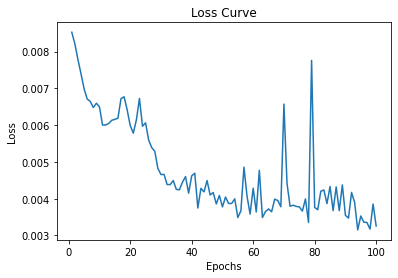

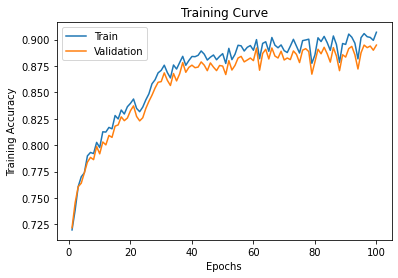

In [ ]:
ann = ANN()
train(ann, train_data, val_data, num_epochs=100, batch_size=64, learning_rate= 0.007)

In [ ]:
test_loader = torch.utils.data.DataLoader(torch.Tensor(test_data.values), batch_size=64, num_workers=1)

In [ ]:
get_accuracy(ann, test_loader)

0.9063550420168067

In [ ]:
get_test_accuracy(ann, test_loader)

True positive:  1464.0 Percentage:  0.9037037037037037
False positive:  156.0 Percentage:  0.0962962962962963
True negative:  1467.0 Percentage:  0.9
False negaive:  163.0 Percentage:  0.1

Test accuracy:  0.9063550420168067
